In [1]:
import argparse
import sys
import os
# Parent folder imports
current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from data_loading_sym import PartialMNIST_AE_Dataloader, RotMNIST_AE_Dataloader
from collections import OrderedDict
from modules_sym import PartEqMod
import pytorch_lightning as pl


# Configuration
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=0)
parser.add_argument("--dataloader_batch_sz", type=int, default=256)

# Dataset
parser.add_argument("--dataset_root", type=str,
                    default="../datasets")
parser.add_argument("--dataset", type=str,
                    default="PartMNIST")
parser.add_argument("--customdata_train_path", type=str,
                    default="../datasets/mnist60/invariant_dataset_train.pkl")
parser.add_argument("--customdata_test_path", type=str,
                    default="../datasets/mnist60/invariant_dataset_test.pkl")


# Net params
parser.add_argument("--in_channels", default=1, type=int)  # Size of the networks in Inv AE
parser.add_argument("--hidden_dim", default=128, type=int)  # Size of the networks in Inv AE
parser.add_argument("--emb_dim", default=32, type=int)  # Dimension of latent spaces
parser.add_argument("--hidden_dim_theta", default=64, type=int)  # Size of theta network
parser.add_argument("--emb_dim_theta", default=100, type=int)  # Size of embedding space in theta network
parser.add_argument("--use_one_layer", action='store_true', default=False)
parser.add_argument("--pretrained_path", type=str, default="./")  # Pretrained Model Path
# Cyclic groups
parser.add_argument("--n_cyclic_groups", type=int, default=8)  # Number of cyclic groups to classify in
parser.add_argument("--discrete_groups", action='store_true', default=False)  # Cyclic symmetries

config, _ = parser.parse_known_args()

# Set seed
if config.seed == -1:
    config.seed = np.random.randint(0, 100000)
pl.seed_everything(config.seed)

c:\users\uualo\documents\vu ai\thesis\code\so2unsupervised\.venv\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Global seed set to 0


0

In [2]:
# Change accordingly
EXPERIMENT = "MNISTMULTIPLE"

In [3]:
if "MNIST" in EXPERIMENT:
        config.in_channels = 1
        config.emb_dim_theta = 128
        config.hidden_dim_theta = 64
        num_classes = 10
        if EXPERIMENT == "ROTMNIST60":
            config.customdata_test_path = "../datasets/mnist60_test.pkl"
            config.pretrained_path = "../models/mnist60/best_model_theta.pt"
            # Net
            config.hidden_dim = 64
            config.emb_dim = 200
        if EXPERIMENT == "ROTMNIST60-90":
            config.customdata_test_path = "../datasets/mnist60_90_test.pkl"
            config.pretrained_path = "../models/mnist6090/best_model_theta.pt"
            # Net
            config.hidden_dim = 64
            config.emb_dim = 200
        if EXPERIMENT == "MNISTMULTIPLE":
            config.customdata_test_path = "../datasets/mnist_multiple_test.pkl"
            config.pretrained_path = "../models/mnistmultiple/best_model_theta.pt"
            # Net
            config.hidden_dim = 64
            config.emb_dim = 200
        if EXPERIMENT == "MNISTMULTIPLE_GAUSSIAN":
            config.customdata_test_path = "../datasets/mnist_multiple_gaussian_test.pkl"
            config.pretrained_path = "../models/mnistgaussian/best_model_theta.pt"
            # Net
            config.hidden_dim = 64
            config.emb_dim = 200
        if EXPERIMENT == "ROTMNIST":
            config.customdata_test_path = "../datasets/mnist_all_rotation_normalized_float_test.amat"
            config.pretrained_path = "../models/mnistrot/best_model_theta.pt"
            # Net
            config.hidden_dim = 64
            config.emb_dim = 200
        if EXPERIMENT == "MNISTC2C4":
            config.customdata_test_path = "../datasets/mnist_c2c4_train.pkl"
            config.pretrained_path = "../models/mnistc2c4/best_model_theta.pt"
            # Net
            config.hidden_dim = 164
            config.emb_dim = 200
            config.hidden_dim_theta = 32
            config.emb_dim_theta = 100
            config.discrete_groups = True
        if EXPERIMENT == "MNIST":
            config.customdata_test_path = "../datasets/mnist_test.amat"
            config.pretrained_path = "../models/mnist/best_model_theta.pt"
            # Net
            config.hidden_dim = 100
            config.emb_dim = 200

In [4]:
%%capture
# Load SSL-SYM model
net = PartEqMod(hparams=config)
state_dict = torch.load(config.pretrained_path)

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("model.", "")  # remove "model."
    new_state_dict[name] = v
keys_to_load = {k: v for k, v in new_state_dict.items()}

print(f"Loading pre-trained model for {EXPERIMENT}.")

net.load_state_dict(keys_to_load, strict=False)
net.cuda()
net.eval()


In [5]:
# Load the data.
if ".pkl" in config.customdata_test_path:
    test_dataloader = PartialMNIST_AE_Dataloader(config, train=False, test=True, shuffle=True,
                                                 no_val_split=True)
    test_dataloader = test_dataloader[0]
if ".amat" in config.customdata_test_path:
    test_dataloader = RotMNIST_AE_Dataloader(config, train=False, test=True, shuffle=True,
                                             no_val_split=True)
    test_dataloader = test_dataloader[0]

Loading for train: False , and for test: True


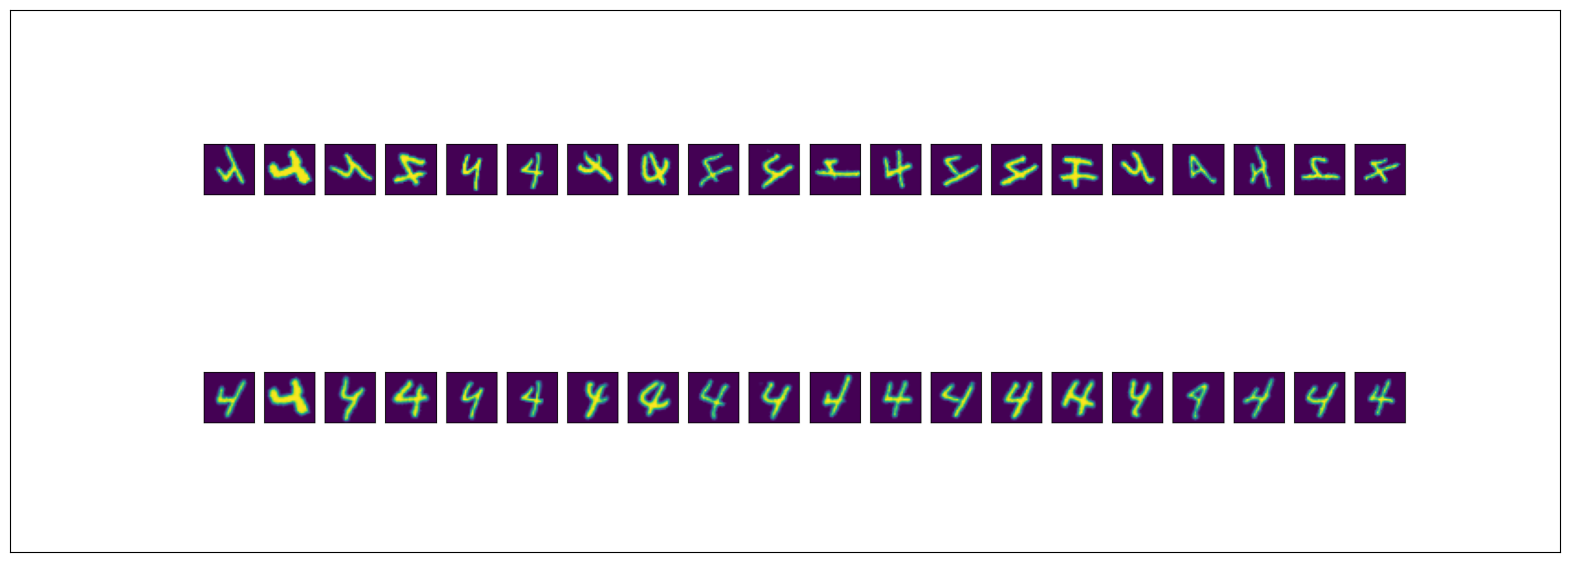

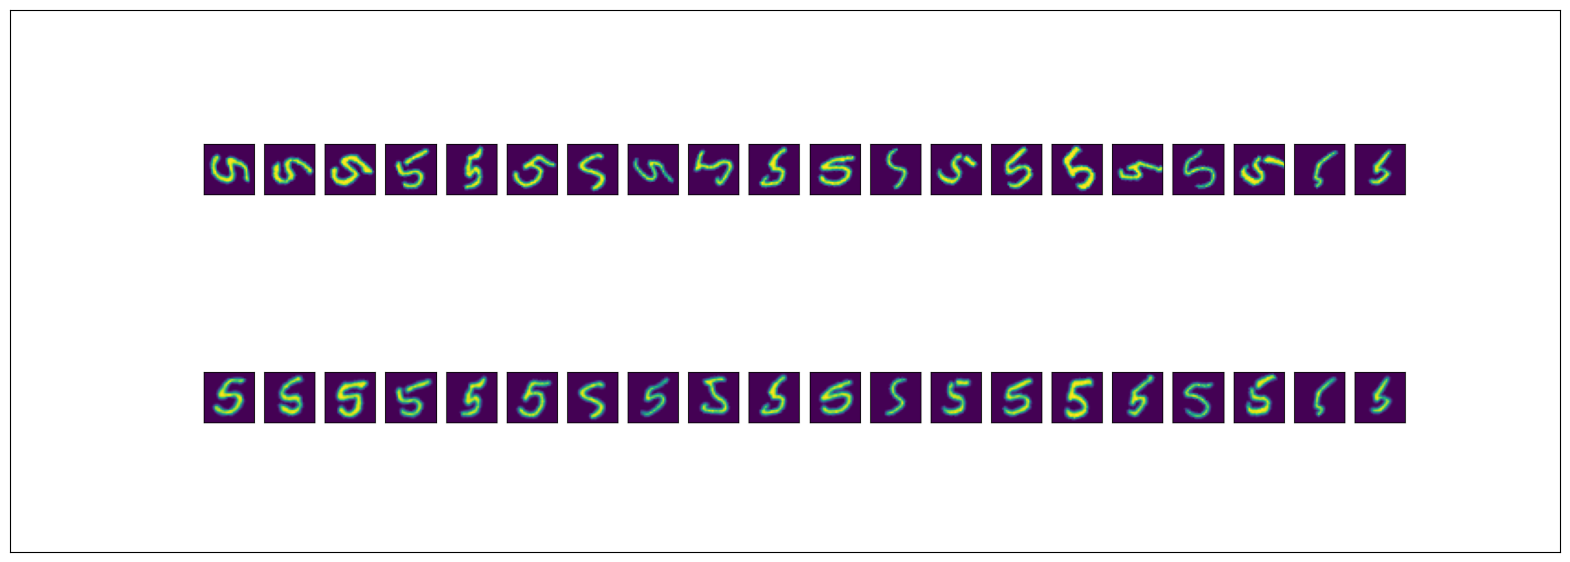

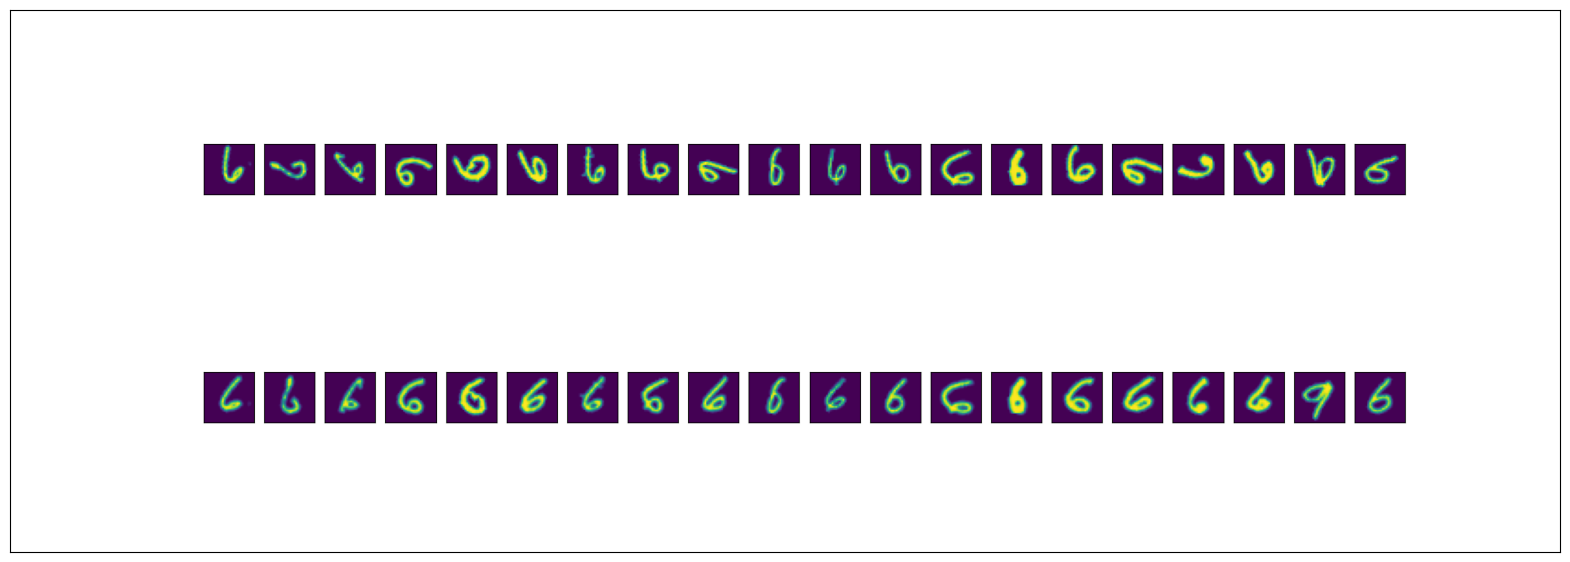

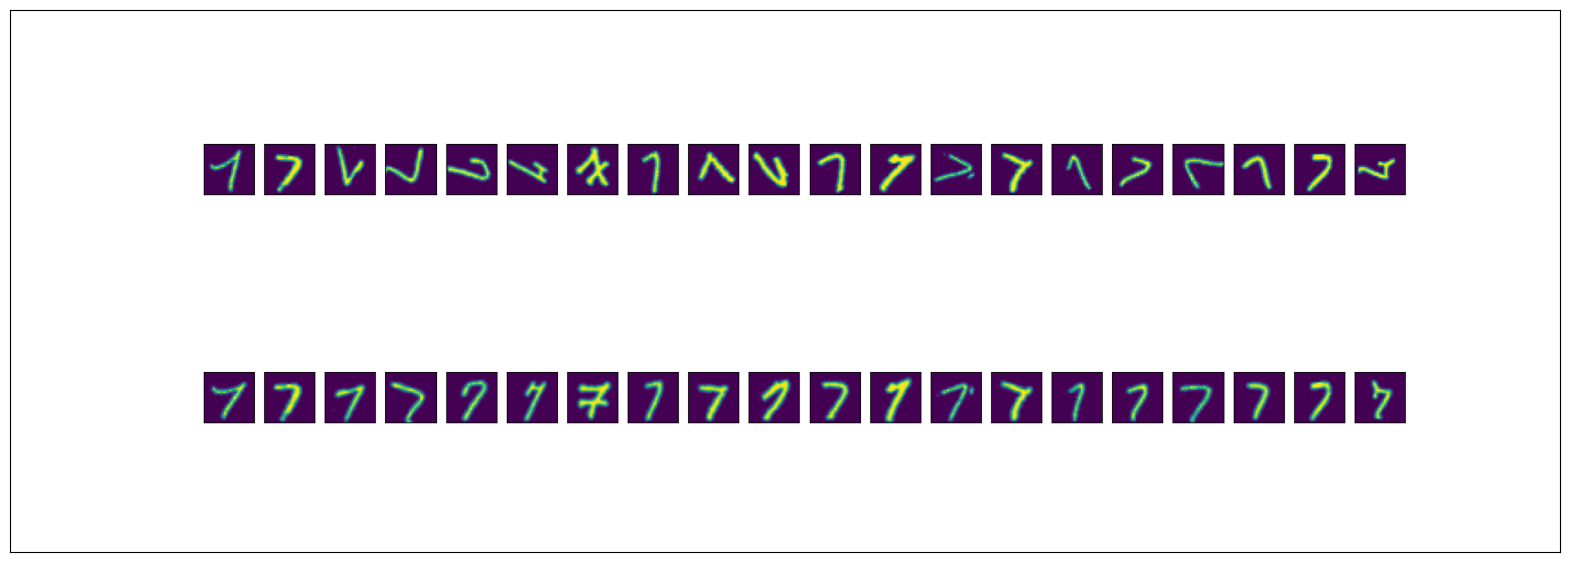

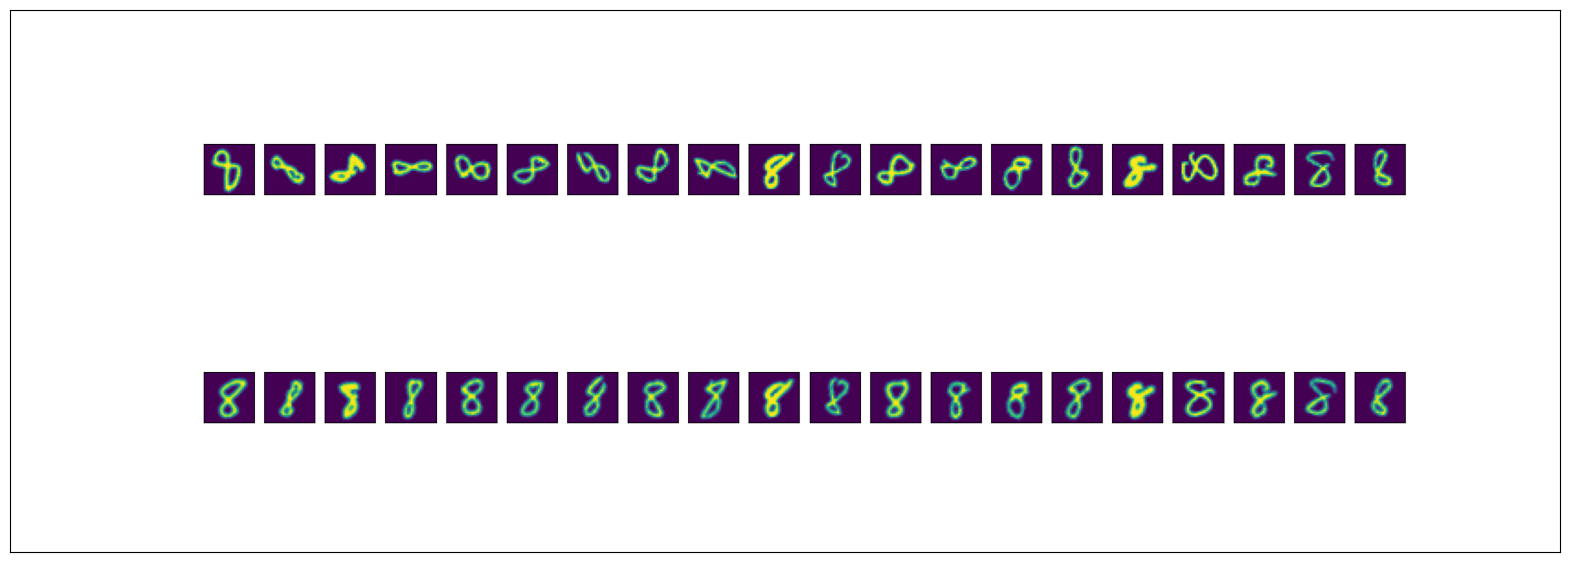

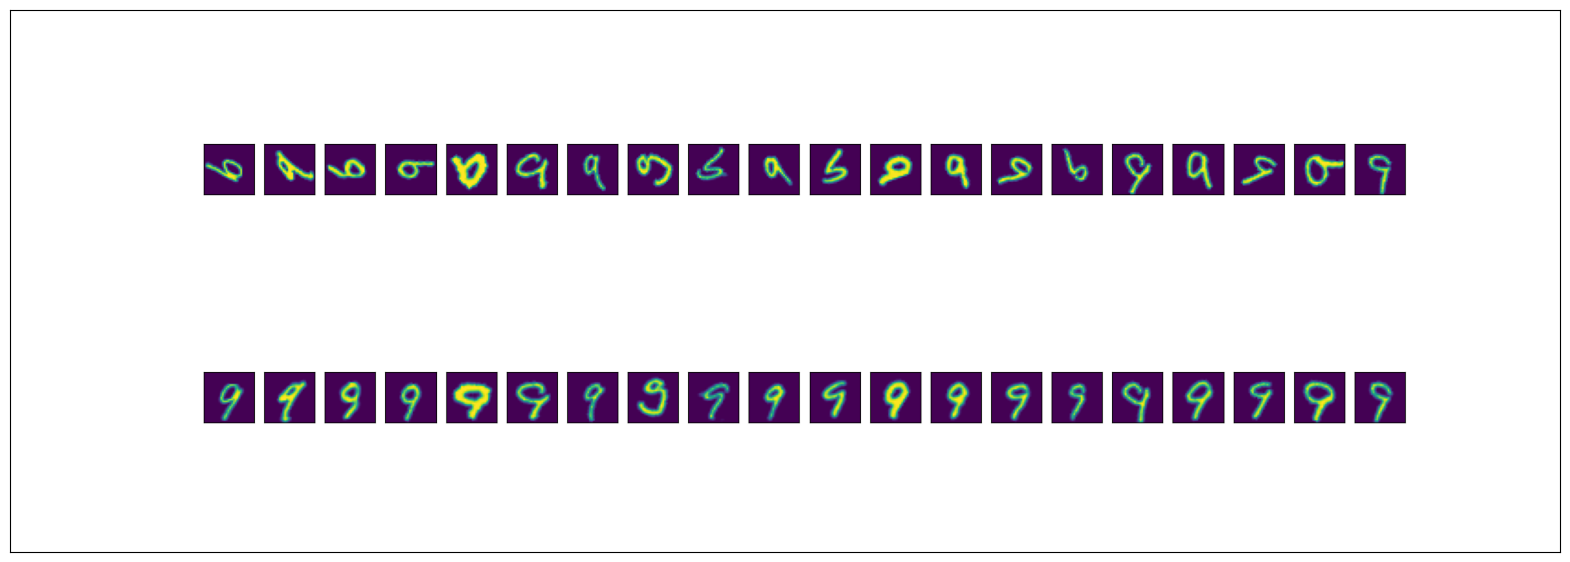

In [6]:
# Visualizations of inputs, canonicals and reconstructions
# Visualize a random sample from the dataset
os.makedirs(f"./plots/{EXPERIMENT}", exist_ok=True)
sample_size = 20
fig, ax = plt.subplots(nrows=3, ncols=sample_size, figsize=(20, 7))
fig_2, ax_2 = plt.subplots(nrows=2, ncols=sample_size, figsize=(20, 7))
for x, label in test_dataloader:
    x = x.cuda()
    label = label.long().cuda()
    assert sample_size < x.shape[0]

    with torch.no_grad():
        # Encoder pass
        emb, v = net.encoder(x)
        rot = net.get_rotation_matrix(v)
        degrees_rot = net.get_degrees(rot)

        # Canonical and recon pass
        canonical_rep = net.decoder(emb)
        recon = net.rot_img(canonical_rep, rot)

        # Standarized versions
        oriented = net.rot_img(x, rot, rot_inverse=True)

    # Visualization of canonicals/recon of random sample
    for j in range(sample_size):
        ax[0, j].imshow(x[j].cpu().permute(1,2,0).squeeze())
        ax[0, j].set_xticks([])
        ax[0, j].set_yticks([])
        ax[1, j].imshow(canonical_rep[j].detach().permute(1,2,0).cpu().squeeze())
        ax[1, j].set_xticks([])
        ax[1, j].set_yticks([])
        ax[2, j].imshow(recon[j].detach().permute(1,2,0).cpu().squeeze())
        ax[2, j].set_xticks([])
        ax[2, j].set_yticks([])

    # Visualization of generated standarized datasets
    for j in range(sample_size):
        ax_2[0, j].imshow(x[j].permute(1,2,0).cpu().squeeze())
        ax_2[0, j].set_xticks([])
        ax_2[0, j].set_yticks([])

        img_or = oriented[j].detach().permute(1,2,0).squeeze().cpu()
        ax_2[1, j].imshow(img_or)
        ax_2[1, j].set_xticks([])
        ax_2[1, j].set_yticks([])

    break
# Save figures
fig.savefig(f"./plots/{EXPERIMENT}/Canonicals_all.png")
plt.close(fig)

fig_2.savefig(f"./plots/{EXPERIMENT}/Standarized_all.png")
plt.close(fig_2)

# Visualize for each class
sample_size = 20
for target_digit in range(num_classes):
    break_loop = False
    count = 0

    fig, ax = plt.subplots(nrows=3, ncols=sample_size, figsize=(20, 7))
    fig_2, ax_2 = plt.subplots(nrows=2, ncols=sample_size, figsize=(20, 7))

    for x, label in test_dataloader:
        if break_loop:
            break
        x = x.cuda()
        label = label.long().cuda()

        with torch.no_grad():
            # Encoder pass
            emb, v = net.encoder(x)
            rot = net.get_rotation_matrix(v)
            degrees_rot = net.get_degrees(rot)

            # Canonical and recon pass
            canonical_rep = net.decoder(emb)
            recon = net.rot_img(canonical_rep, rot)

            # Standarized versions
            oriented = net.rot_img(x, rot, rot_inverse=True)

        # Plot digits
        for j in range(x.shape[0]):
            if int(label[j].item()) == target_digit:
                ax[0, count].imshow(x[j].cpu().permute(1,2,0).squeeze())
                ax[0, count].set_xticks([])
                ax[0, count].set_yticks([])
                ax[1, count].imshow(canonical_rep[j].detach().permute(1,2,0).cpu().squeeze())
                ax[1, count].set_xticks([])
                ax[1, count].set_yticks([])
                ax[2, count].imshow(recon[j].detach().cpu().permute(1,2,0).squeeze())
                ax[2, count].set_xticks([])
                ax[2, count].set_yticks([])

                ax_2[0, count].imshow(x[j].cpu().permute(1,2,0).squeeze())
                ax_2[0, count].set_xticks([])
                ax_2[0, count].set_yticks([])
                img_or = oriented[j].detach().permute(1,2,0).cpu().squeeze()
                ax_2[1, count].imshow(img_or)
                ax_2[1, count].set_xticks([])
                ax_2[1, count].set_yticks([])

                count += 1

                if count == sample_size:
                    fig.savefig(f"plots/{EXPERIMENT}/Canonical_" + str(target_digit) + ".png")
                    plt.close(fig)

                    fig_2.savefig(f"plots/{EXPERIMENT}/Standardized_" + str(target_digit) + ".png")
                    plt.close(fig_2)
                    break_loop = True
                    break

# Plot some of the saved figures
plot_classes = [4,5,6,7,8,9]
# Read the image from file
for target_digit in plot_classes:
    image_path = f"plots/{EXPERIMENT}/Standardized_" + str(target_digit) + ".png"
    saved_image = mpimg.imread(image_path)
    
    fig, ax = plt.subplots(figsize=(20, 70))
    ax.imshow(saved_image)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

In [7]:
plt.style.use('seaborn-whitegrid')
# Evaluate model on test set calculating lvl of symmetry prediction scores

thetas_dict = {i: [] for i in range(num_classes)}
labels_dict = {i: [] for i in range(num_classes)}
all_thetas_dict = {i: [] for i in range(num_classes)}

all_transforms = []
all_transforms_dict = {i: [] for i in range(num_classes)}
# Insert true level of rotation of each dataset
if EXPERIMENT == "ROTMNIST60":
    true_thetas_dict = {0: 60., 1: 60., 2: 60., 3: 60., 4: 60.,
                        5: 60., 6: 60., 7: 60., 8: 60., 9: 60.}
elif EXPERIMENT == "ROTMNIST60-90":
    true_thetas_dict = {0: 60., 1: 60., 2: 60., 3: 60., 4: 60.,
                        5: 90., 6: 90., 7: 90., 8: 90., 9: 90.}
elif EXPERIMENT == "MNISTMULTIPLE":
    true_thetas_dict = {0: 0, 1: 18, 2: 36, 3: 54, 4: 72,
                        5: 90, 6: 108, 7: 126, 8: 144, 9: 162}
elif EXPERIMENT == "MNISTMULTIPLE_GAUSSIAN":
    std_dev_dict = {0: 0, 1: 9, 2: 18, 3: 27, 4: 36,
                    5: 45, 6: 54, 7: 63, 8: 72, 9: 81}
    true_thetas_dict = std_dev_dict
elif EXPERIMENT == "ROTMNIST":
    true_thetas_dict = {0: 180., 1: 180., 2: 180., 3: 180., 4: 180.,
                        5: 180., 6: 180., 7: 180., 8: 180., 9: 180.}
elif EXPERIMENT == "MNIST":
    true_thetas_dict = {0: 0., 1: 0., 2: 0., 3: 0., 4: 0.,
                        5: 0., 6: 0., 7: 0., 8: 0., 9: 0.}
elif EXPERIMENT == "MNISTC2C4":
    true_thetas_dict = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1,  # class 0 is C1, class 1 is C2...
                        5: 3, 6: 3, 7: 3, 8: 3, 9: 3}
else:
    ValueError("Dataset not implemented")

net.eval()
for x, label in test_dataloader:
    x = x.cuda()
    label = label.long().cuda()

    with torch.no_grad():
        # Encoder pass
        emb, v = net.encoder(x)
        rot = net.get_rotation_matrix(v)
        degrees_rot = net.get_degrees(rot)

        # Theta function
        degrees_theta = net.theta_function(x).squeeze()
        if config.discrete_groups:
            degrees_theta = torch.argmax(degrees_theta, dim=1)
        all_transforms.extend(degrees_rot.cpu().numpy())

        # Loop through each class and gather rotations
        for lab in range(num_classes):
            mask = (label == lab)

            # Extract values
            sub_thetas = degrees_theta[mask].cpu().numpy()
            sub_labels = label[mask].cpu().numpy()
            sub_degrees = degrees_rot[mask].cpu().numpy()

            # Save the values
            mean_degrees = np.nanmean(sub_thetas)  # Beware of nan values when the mask is all False
            thetas_dict[lab].append(mean_degrees)
            labels_dict[lab].extend(sub_labels.tolist())
            all_thetas_dict[lab].extend(sub_thetas.tolist())
            all_transforms_dict[lab].extend(sub_degrees.tolist())

symmetry_level_error = 0.
final_results = {}
for lab in range(num_classes):
    print(f"\n====== Results for class {lab} ======")

    # Nan values
    nan_values = np.sum(np.isnan(thetas_dict[lab]))
    print("\nNan values: " + str(nan_values))

    # Calculate mean of thetas, per-digit
    mean_value = np.nanmean(thetas_dict[lab])
    print(f'\nMean Value of Symmetry Predictions:{lab}: {mean_value}')
    # Calculate MAE
    if len(all_thetas_dict[lab]) > 0:
        differences = np.array(all_thetas_dict[lab]) - true_thetas_dict[lab]
        if not np.all(np.isfinite(differences)):
            print(f"Warning: Some non-finite values detected for lab={lab} after subtraction.")
            differences = np.nan_to_num(
                differences)  # Replace NaNs and infinite values with 0 (or another appropriate value)

        mae_value = np.mean(np.abs(differences))
        symmetry_level_error += mae_value
        print(f'\nMAE for class {lab} : {mae_value}')

        # Calculate standard deviation
        std_dev = np.std(differences)
        print(f'\nStd dev for class {lab} : {std_dev}\n')
        # Save to dict
        final_results[lab] = (mean_value, std_dev)
    else:
        print(f'\nMAE for class {lab} : Not Computed due to empty array')
        print(f'\nStd dev for class {lab} : Not Computed due to empty array\n')
# Save the final result in a csv
df_results = pd.DataFrame.from_dict(final_results, orient="index", columns=["Mean", "Standard Deviation"])
df_results.to_csv(f"plots/{EXPERIMENT}/" + "final_results.csv")

if config.discrete_groups:
    final_results = {}
    for lab in range(num_classes):
        print(f"\n====== Results for class {lab} ======")

        # Nan values
        nan_values = np.sum(np.isnan(thetas_dict[lab]))
        print("\nNan values: " + str(nan_values))

        # Count correct predictions
        true_thetas_array = np.repeat(true_thetas_dict[lab], len(all_thetas_dict[lab]))
        correct_predictions = np.sum(all_thetas_dict[lab] == true_thetas_array)
        total_predictions = len(true_thetas_array)

        # Calculate accuracy
        if total_predictions > 0:
            accuracy = correct_predictions / total_predictions
            print(f'\nAccuracy for class {lab}: {accuracy}')

            # Save to dict
            final_results[lab] = accuracy
        else:
            print('\nAccuracy for class {lab}: Not Computed due to empty array\n')
    # Save the final result in a csv
    df_results = pd.DataFrame.from_dict(final_results, orient="index", columns=["Accuracy"])
    df_results.to_csv(f"plots/{EXPERIMENT}/" + "final_results.csv")



        
# Print Histogram for Psi
fig, ax = plt.subplots(figsize=(12, 8))
df = pd.DataFrame()
df["psi"] = all_transforms
kde = df["psi"].plot.kde(ax=ax, label="_nolegend_", lw=2)
# Get x and y values of the KDE curve
x, y = kde.get_lines()[0].get_data()
ax.fill_between(x, y, color="skyblue", alpha=0.5)
plt.xlim(-180, 180)
ax.set_xlabel("Angle of Rotation (º)", fontsize=16)
plt.yticks([])
ax.set_ylabel("")
# Adjust fontsize for tick labels
ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)
ax.set_ylim(bottom=0)
plt.title("Density of Group Action Estimator (Test Set)", fontsize=16)
plt.savefig(f"plots/{EXPERIMENT}/histogram.png")
plt.close(fig)

# Print Histogram for Psi per label
for lab in range(num_classes):
    fig, ax = plt.subplots(figsize=(12, 8))
    df = pd.DataFrame()
    df["psi"] = all_transforms_dict[lab]
    kde = df["psi"].plot.kde(ax=ax, label="_nolegend_", lw=2)
    # Save the psi values for later visualization purposes
    df.to_csv(f"plots/{EXPERIMENT}/rotations_class_" + str(lab) + ".csv", index=False)
    # Get x and y values of the KDE curve
    x, y = kde.get_lines()[0].get_data()
    ax.fill_between(x, y, color="skyblue", alpha=0.5)
    plt.xlim(-180, 180)
    ax.set_xlabel("Angle of Rotation (º)", fontsize=16)
    plt.yticks([])
    ax.set_ylabel("")
    # Adjust fontsize for tick labels
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_ylim(bottom=0)
    plt.title("Density of Group Action Estimator (Test Set)", fontsize=16)
    plt.savefig(f"plots/{EXPERIMENT}/histogram" + str(lab) + ".png")
    plt.close(fig)

C:\Users\uualo\AppData\Local\Temp\ipykernel_21268\3914086322.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')



====== Results for class 0 ======

Nan values: 0

Mean Value of Symmetry Predictions:0: 8.664807319641113

MAE for class 0 : 8.677545248245622

Std dev for class 0 : 9.530141980870486


====== Results for class 1 ======

Nan values: 0

Mean Value of Symmetry Predictions:1: 4.8827738761901855

MAE for class 1 : 15.615547998759151

Std dev for class 1 : 11.366005031308038


====== Results for class 2 ======

Nan values: 0

Mean Value of Symmetry Predictions:2: 35.28171920776367

MAE for class 2 : 11.800794286790834

Std dev for class 2 : 17.364689966832508


====== Results for class 3 ======

Nan values: 0

Mean Value of Symmetry Predictions:3: 58.862060546875

MAE for class 3 : 8.86664620565575

Std dev for class 3 : 12.017997159416513


====== Results for class 4 ======

Nan values: 0

Mean Value of Symmetry Predictions:4: 75.61162567138672

MAE for class 4 : 8.83297883605957

Std dev for class 4 : 13.644934268957757


====== Results for class 5 ======

Nan values: 0

Mean Value of Sy

   Unnamed: 0        Mean  Standard Deviation
0           0    8.664807            9.530142
1           1    4.882774           11.366005
2           2   35.281720           17.364690
3           3   58.862060           12.017997
4           4   75.611626           13.644934
5           5   88.338130           10.405447
6           6  106.898186           14.320821
7           7  117.888840           17.561140
8           8  134.052490           16.841635
9           9  156.392620           23.837302


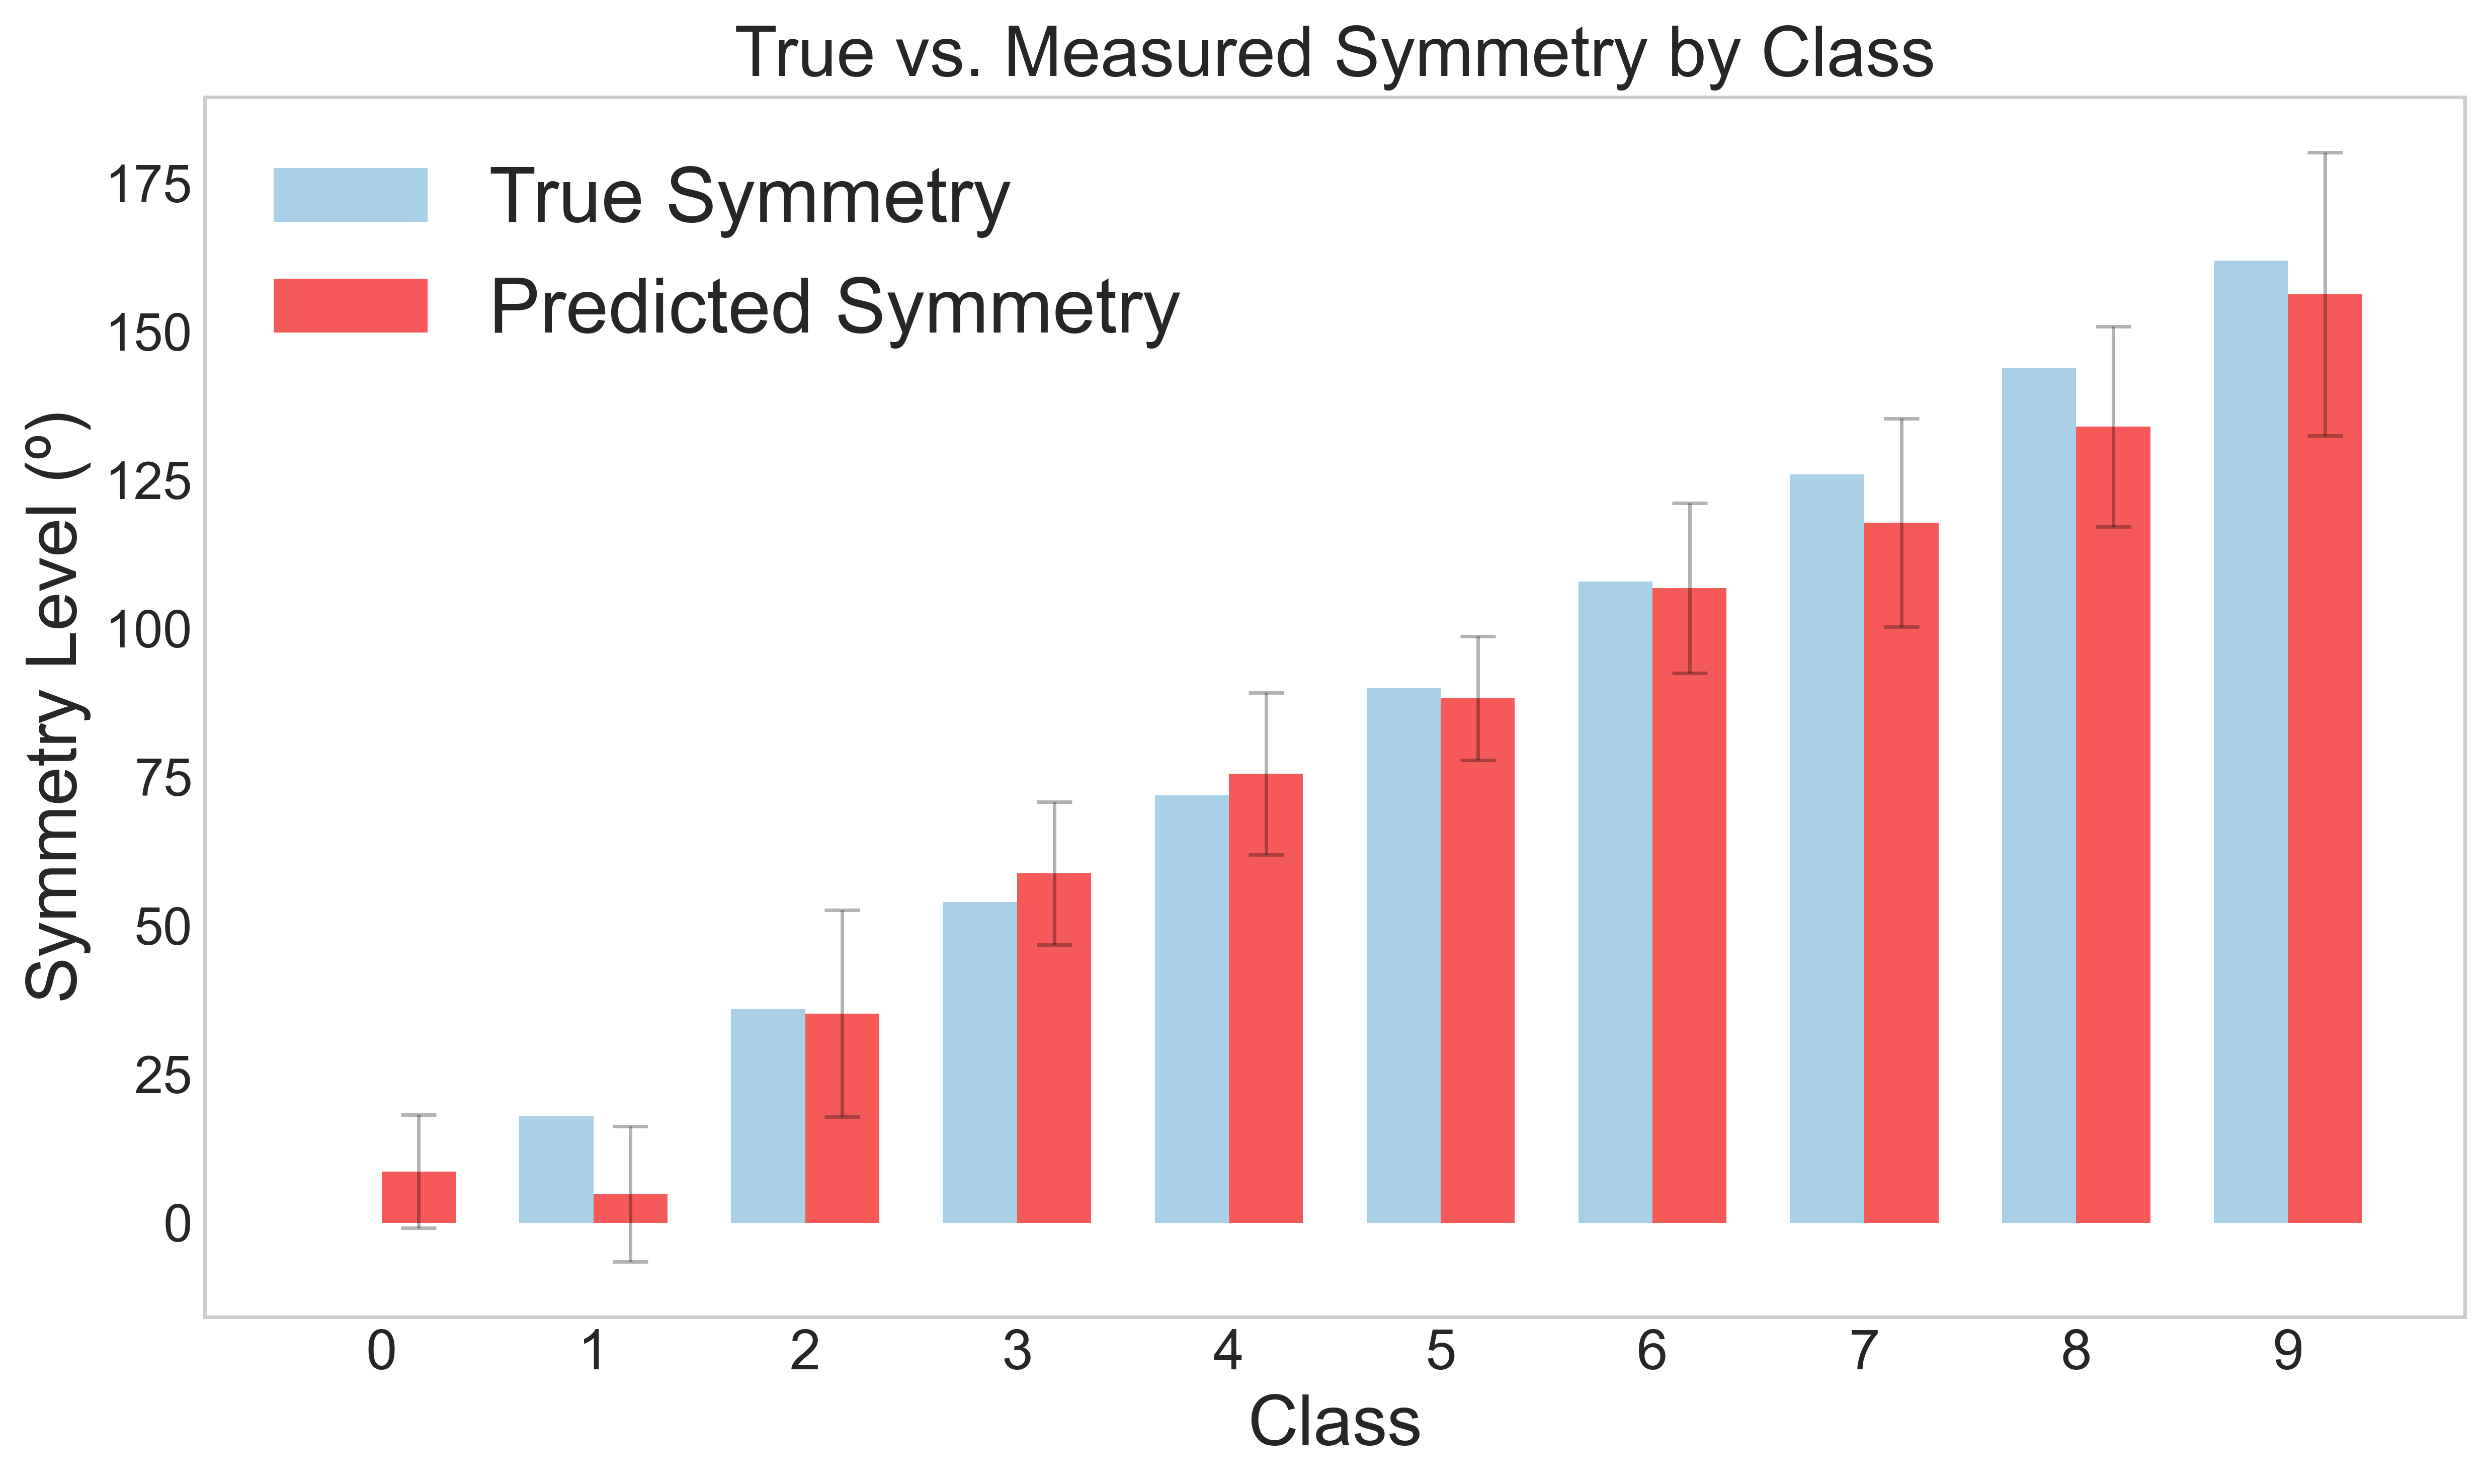

In [8]:
# Final results plot
os.makedirs(f"./plots/{EXPERIMENT}", exist_ok=True)
def plot_final_results(csv_path, true_thetas_dict):
        
    df = pd.read_csv(final_results_path)
    print(df)
    fig, ax = plt.subplots(figsize=(10, 6), dpi=500)
    
    ind = np.arange(num_classes)
    width = 0.35
    
    # Bar plots
    if config.discrete_groups:
        rects2 = ax.bar(ind + width/2, df['Accuracy'], width, label='Accuracy', color='#f55a58', capsize=5, ecolor='black', error_kw=dict(lw=1, capthick=1, alpha=0.3))
    else:
        rects1 = ax.bar(ind - width/2, true_thetas_dict.values(), width, label='True Symmetry', color='#a8d0e6')
        rects2 = ax.bar(ind + width/2, df['Mean'], width, yerr=df['Standard Deviation'], label='Predicted Symmetry', color='#f55a58', capsize=5, ecolor='black', error_kw=dict(lw=1, capthick=1, alpha=0.3))
    
    ax.set_xlabel('Class', fontsize=20)
    if config.discrete_groups:
        ax.set_ylabel('Accuracy', fontsize=20)
        ax.set_ylim(0, 1.19)  # Manually adjust to fit bars under legend
        plt.yticks(fontsize=17)
    else:
        ax.set_ylabel('Symmetry Level (º)', fontsize=20)
    #ax.set_ylim(0, max(df['Mean'])+25)  # Manually adjust to fit bars under legend
    ax.set_title('True vs. Measured Symmetry by Class', fontsize=20)
    if config.discrete_groups:
        ax.set_xticks(list(range(9)))
        ax.set_xticklabels(list(range(9)), fontsize=16)
        plt.axhline(1., linestyle='--', color="r")
    else:
        ax.set_xticks(ind)
        ax.set_xticklabels(df.index, fontsize=16)
    plt.yticks(fontsize=15)
    ax.legend(fontsize=22, loc='upper left')
    
    
    plt.tight_layout()
    plt.grid(False)
    plt.savefig(f"plots/{EXPERIMENT}/symmetry_levels_results.png")
    plt.show()
    
final_results_path = f"plots/{EXPERIMENT}/" + "final_results.csv"  # This file with the results is created in the previous cell
plot_final_results(final_results_path, true_thetas_dict)


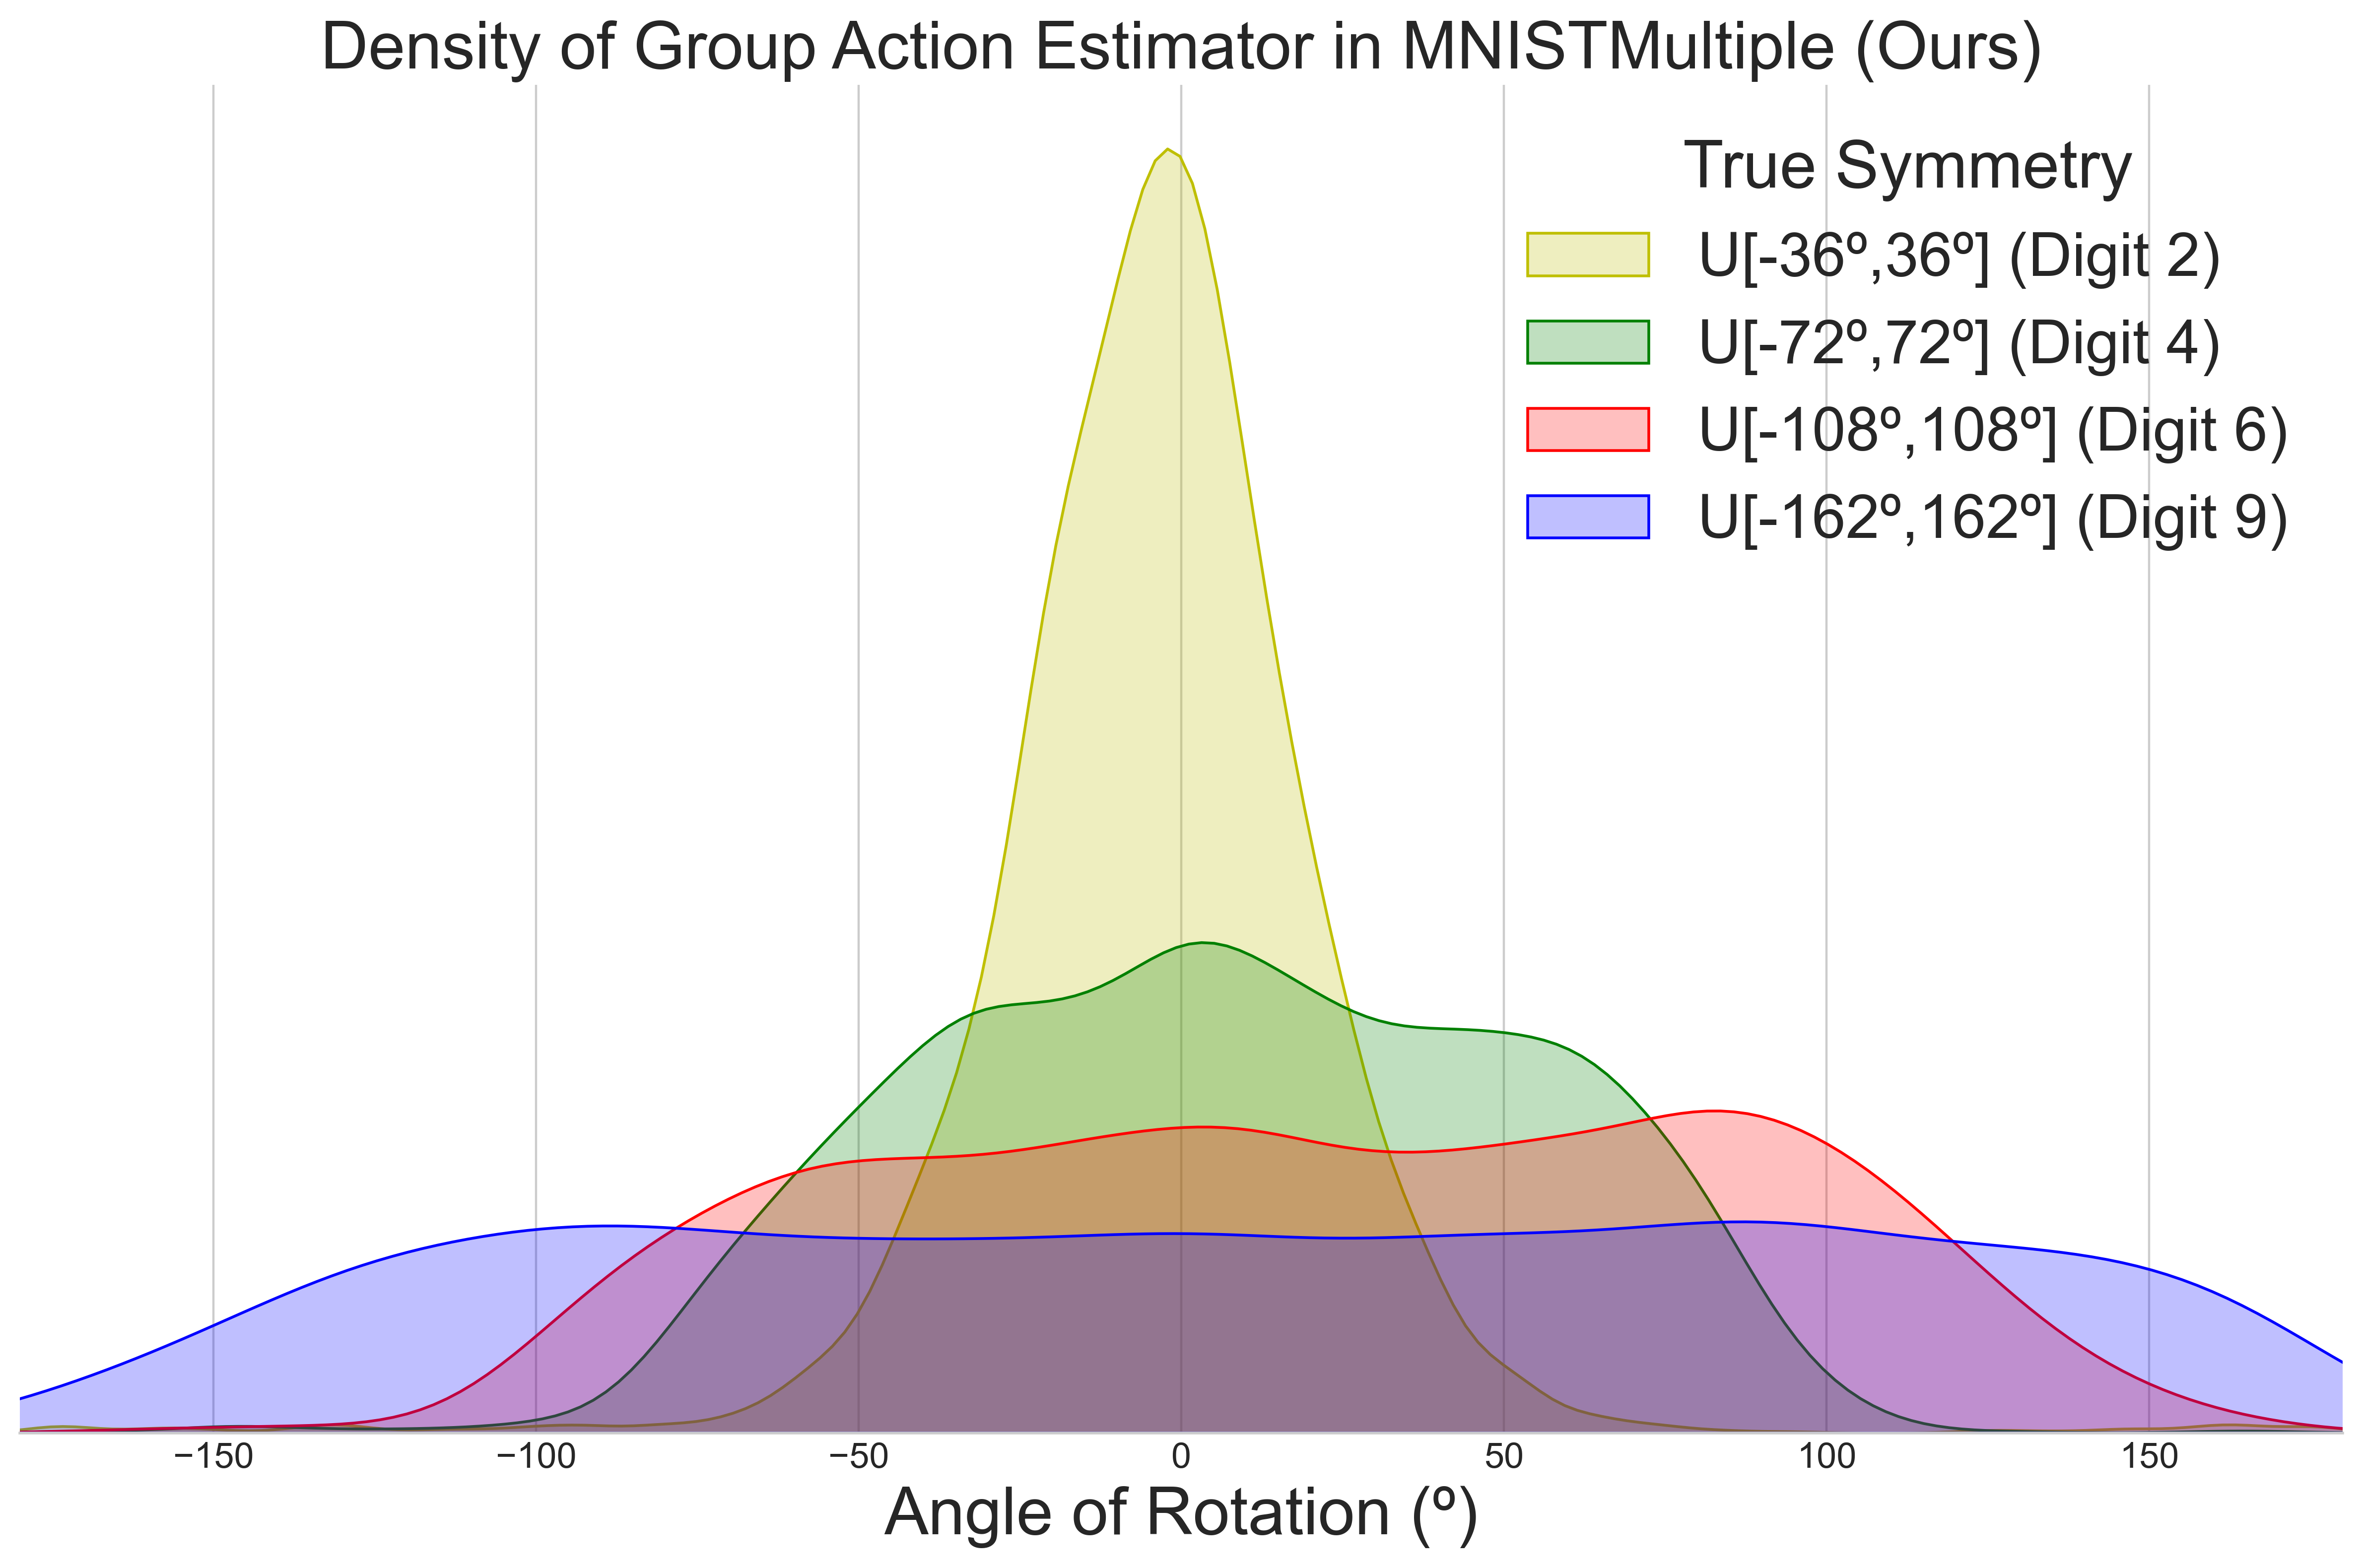

In [9]:
# MNISTMultiple Densities Plot

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams["mathtext.default"]

# Load the data for different classes

# Here we plot only for MNISTMultiple, but the rotations_class_x.csv files are created for other experiments
# in other notebooks/previous cells, and equivalent plots can be created for those experiments.

df_6 = pd.read_csv("./plots/mnistmultiple/rotations_class_6.csv") 
df_2 = pd.read_csv("./plots/mnistmultiple/rotations_class_2.csv")
df_4 = pd.read_csv("./plots/mnistmultiple/rotations_class_4.csv")
df_9 = pd.read_csv("./plots/mnistmultiple/rotations_class_9.csv")

plt.figure(figsize=(12, 8), dpi=400)

# Plot KDE for each class
sns.kdeplot(df_2['psi'], fill=True, color="y", label="U[-36º,36º] (Digit 2)")
sns.kdeplot(df_4['psi'], fill=True, color="g", label="U[-72º,72º] (Digit 4)")
sns.kdeplot(df_6['psi'], fill=True, color="r", label="U[-108º,108º] (Digit 6)")
sns.kdeplot(df_9['psi'], fill=True, color="b", label="U[-162º,162º] (Digit 9)")

plt.xlabel("Angle of Rotation (º)", fontsize=24)
plt.xlim(-180, 180)
plt.xticks(fontsize=13)
plt.yticks([])
plt.ylabel("")
plt.title("Density of Group Action Estimator in MNISTMultiple (Ours)", fontsize=24)
plt.legend(title='True Symmetry', title_fontsize='24', fontsize='22')

sns.despine(left=True)

plt.tight_layout()
plt.savefig("./plots/mnistmultiple/joint_density.png")
plt.show()
